In [1]:
USE_YAM = False
if not USE_YAM:
    DID = ''
else:
    DID = 'y'

In [2]:
import random
import math
import os
import csv

from scipy import stats

import numpy as np
import pandas as pd

from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import motifs
from Bio.motifs import parse

import pickle

from tqdm.notebook import tqdm

from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import fdrcorrection

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

from umap.umap_ import UMAP

import matplotlib.pyplot as plt
import seaborn as sns
import umap.plot  # pip install umap-learn[plot]
import plotly
from plotly import version
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px
random.seed(2021)

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
plt.rcParams ['grid.linestyle'] = ':'
plt.rcParams ['grid.linewidth'] = 2
plt.rcParams ["axes.grid"] =True
plt.rcParams['image.cmap'] = 'Oranges'
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = 'poppins'
plt.rcParams['figure.figsize'] =  (12,12)

In [5]:
if not USE_YAM:
    utr_seq = pd.read_csv('../processed_data/utrs.csv', header = 0)
    utr_seq = utr_seq.loc[:,['Gene Name', 'foreign']]
    utr_seq.rename(columns = {'Gene Name':'gene', 'foreign':'utr_seq'}, inplace = True)
    utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
    utr_seq = utr_seq.loc[utr_seq.gene.notna()]
    utr_seq
    genes_fi = pd.read_csv('../processed_data/fluorescence_dataset.csv')
    genes_fi.dropna(subset=['intensity'],inplace=True)
    genes_fi = genes_fi.loc[genes_fi.intensity.notna()]
    original = genes_fi.shape[0]
    genes_fi = genes_fi.loc[genes_fi.intensity > 0]
    # genes_fi.intensity, _ = stats.boxcox(genes_fi.intensity)
    fi_trans = [math.log(fi) for fi in genes_fi.intensity]
    genes_fi.intensity = fi_trans
    genes_fi = genes_fi.loc[genes_fi.intensity > -20]
    genes_fi
    df = pd.merge(genes_fi, utr_seq, on = 'gene')
    df = df.loc[df.intensity.notna()]
    df.drop_duplicates(inplace = True)
else:
    utr_seq = pd.read_csv('../processed_data/yamanishi_data.csv', header = 0)
    utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
    utr_seq = utr_seq.loc[utr_seq.gene.notna()]
    utr_seq
    df = utr_seq
    df = df.loc[df.intensity.notna()]
    df.drop_duplicates(inplace = True)

In [6]:
original, genes_fi.shape[0]

(5234, 4945)

In [7]:
df['utr_seq'].apply(lambda x: len(x)).min()

6

In [8]:
df = df.loc[df.intensity.notna()]
df.drop_duplicates(inplace = True)

In [9]:
split_points = df['intensity'].quantile(np.arange(0,1,0.1)).values
df['int_group'] = np.digitize(df['intensity'].values, split_points) - 1
bins = np.hstack([split_points, np.max(df['intensity']+0.1)])
bins

array([-8.21662849, -5.13029242, -4.26572215, -3.69650749, -3.2477069 ,
       -2.83959166, -2.37581437, -1.8731311 , -1.27186816, -0.32149722,
        3.64681312])

In [10]:
df.groupby('int_group').gene.count()

int_group
0    364
1    364
2    364
3    364
4    364
5    364
6    364
7    364
8    364
9    364
Name: gene, dtype: int64

### Sequence features extraction

In [11]:
# Length of the sequence
df['len_seq'] = [len(i) for i in df.loc[:,'utr_seq']]
df['len_seq_log'] = [math.log2(len(i)) for i in df.loc[:,'utr_seq']]

findfont: Font family ['poppins'] not found. Falling back to DejaVu Sans.
findfont: Font family ['poppins'] not found. Falling back to DejaVu Sans.


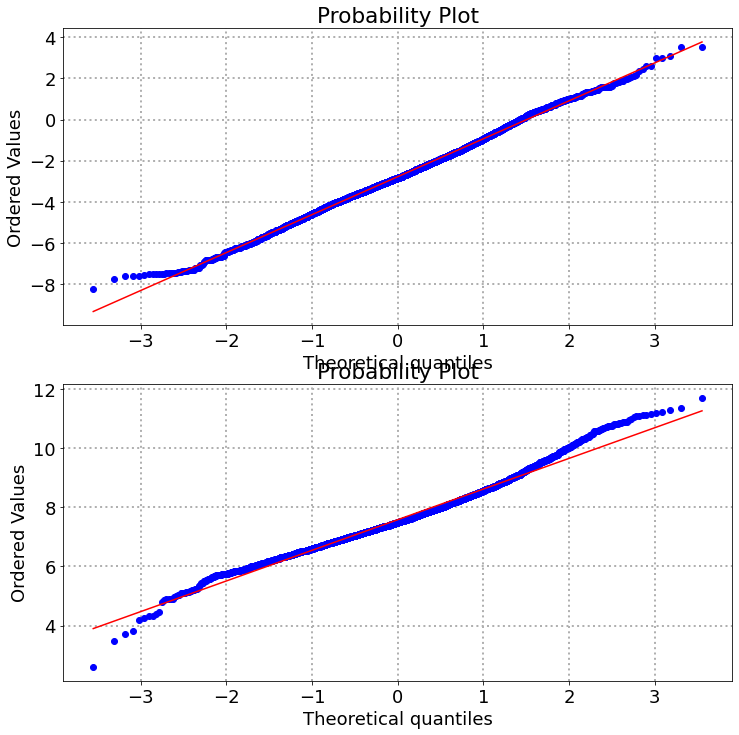

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df.intensity, dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
prob = stats.probplot(df.len_seq_log, dist=stats.norm, plot=ax2)


In [13]:
# AT/GC ratio
df['at_gc'] = [(i.count('A')+i.count('T'))/(i.count('G')+i.count('C')) for i in df.loc[:,'utr_seq']]

In [14]:
# Percent GC
df['pct_gc'] = [SeqUtils.GC(i) for i in df.loc[:,'utr_seq']]

In [15]:
# Molecular weight
df['molecular_w'] = [SeqUtils.molecular_weight(i) for i in df.loc[:,'utr_seq']]

In [16]:
bins

array([-8.21662849, -5.13029242, -4.26572215, -3.69650749, -3.2477069 ,
       -2.83959166, -2.37581437, -1.8731311 , -1.27186816, -0.32149722,
        3.64681312])

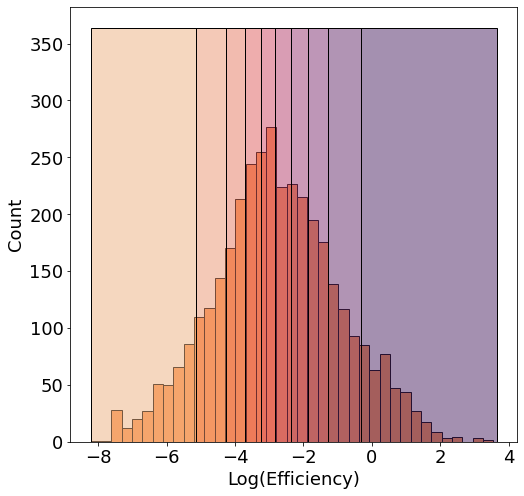

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.histplot(x=df['intensity'], color='#ff781f', ax=axes)
sns.histplot(x=df['intensity'],hue=df['int_group'], bins=bins, palette='flare', ax=axes, legend=False)
axes.set_xlabel('Log(Efficiency)')
axes.grid(False)
fig.set_facecolor('white')
fig.savefig('../figures/FI_transform.png',dpi=300,bbox_inches='tight')

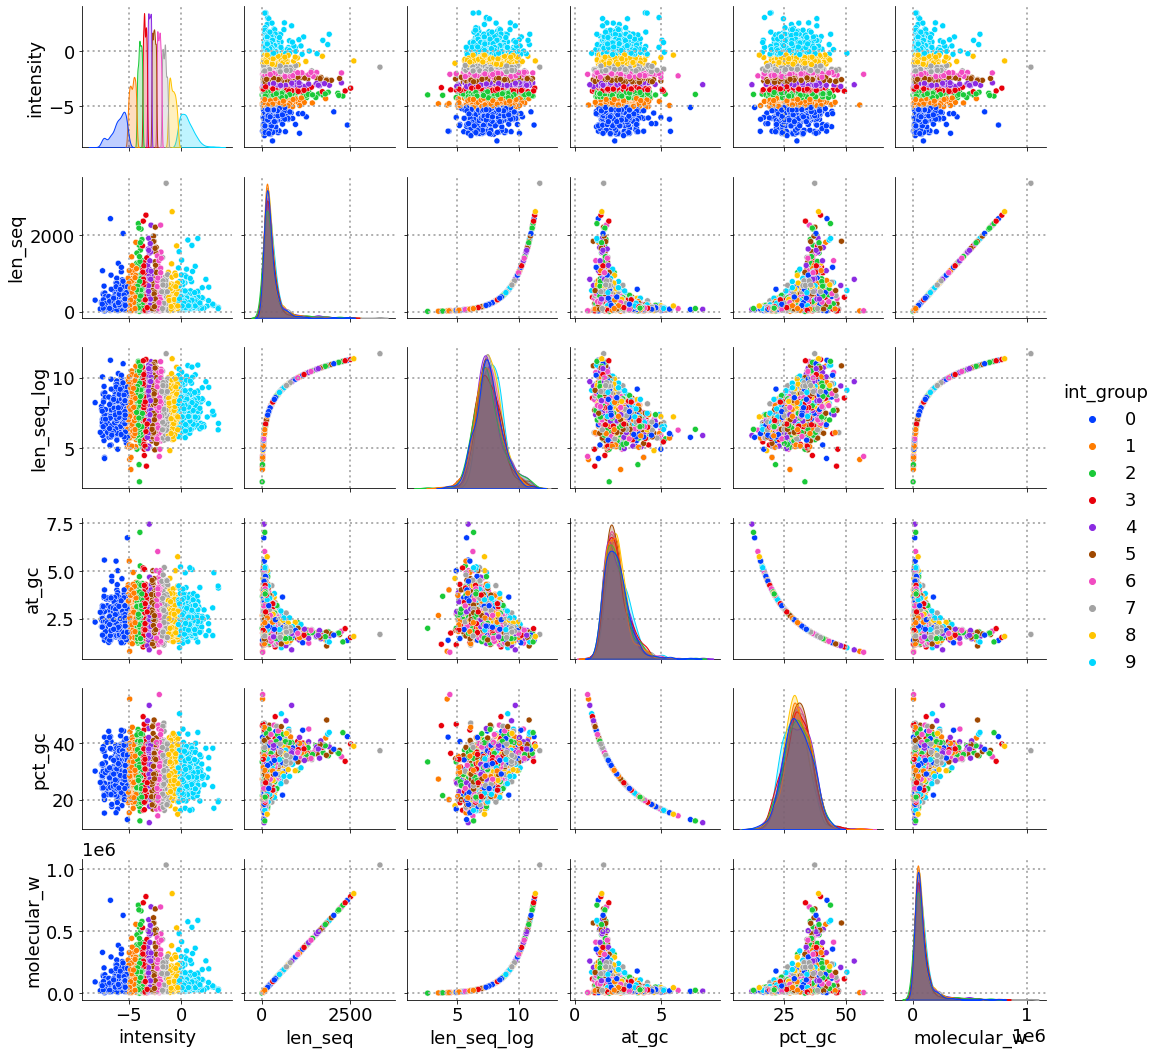

In [18]:
sns.pairplot(df, hue = 'int_group', palette = sns.color_palette('bright', 10))

In [19]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### Per group motif discovery (TBC)

In [20]:
df.head()

gene systematicName  intensity  \
0   SSA1        YAL005C   2.477076   
1   ERP2        YAL007C  -1.204719   
2  FUN14        YAL008W  -0.785451   
3   SPO7        YAL009W  -3.608608   
4   SWC3        YAL011W  -3.443864   

                                             utr_seq  int_group  len_seq  \
0  AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...          9      147   
1  AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...          8      286   
2  AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...          8      128   
3  AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...          3      134   
4  AGGTGTTCGGTTACTTTATTCTGCTTTAACGCCATTATGATTATAC...          3      135   

   len_seq_log     at_gc     pct_gc  molecular_w  
0     7.199672  2.585366  27.891156   45548.2183  
1     8.159871  2.445783  29.020979   88087.5535  
2     7.000000  2.459459  28.906250   39623.4302  
3     7.066089  2.268293  30.597015   41481.5762  
4     7.076816  2.375000  29.629630   41519.5406

In [21]:
os.makedirs('meme_input', exist_ok=True)
def write_file(x):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{x['int_group'].unique()[0]}.fasta", 'w') as out:
        out.write('\n'.join(p.values))
df.groupby('int_group').apply(write_file)

Empty DataFrame
Columns: []
Index: []

In [22]:
def write_inv_file(x, i):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{i}inv.fasta", 'w') as out:
        out.write('\n'.join(p.values))
for cnt in range(10):
    write_inv_file(df[df['int_group'] != cnt], cnt)

In [23]:
os.environ['PATH'] += os.pathsep + '/home/vaslem/meme/bin:/home/vaslem/meme/libexec/meme-5.4.1'

### Trying to find motifs using MEME
- in FI decile group i using background sequences not belonging in i
- in 10th FI decile group using background sequences those in 1st

In [24]:
MINW = 5
MAXW = 10
NMOTIFS = 20
motifs = []
motifs_s = {}
try:
    with open(f'meme_output/{MINW}_{MAXW}_{NMOTIFS}_10{DID}.pkl', 'rb') as inp:
        motifs_s, motifs = pickle.load(inp)
except IOError:
    for cnt in tqdm(range(10)):
        os.system(
            f'meme meme_input/{cnt}{DID}.fasta  -p 8 -objfun de -minw {MINW}'
            f' -maxw {MAXW} -nmotifs {NMOTIFS} -evt 0.01 -oc meme_output/{cnt}{DID}  -dna -neg meme_input/{cnt}{DID}inv.fasta')
        with open(f"meme_output/{cnt}{DID}/meme.txt") as f:
            i_motifs = parse(f, 'MINIMAL')
            motifs_s[cnt] = [str(m.degenerate_consensus) for m in i_motifs]
            motifs.extend(i_motifs)
    os.system(
            f'meme meme_input/9{DID}.fasta  -p 8 -objfun de -minw {MINW}'
            f' -maxw {MAXW} -nmotifs {NMOTIFS} -evt 0.01 -oc meme_output/ex{DID} -dna -neg meme_input/0{DID}.fasta')
    with open(f"meme_output/ex{DID}/meme.txt") as f:
        i_motifs = parse(f, 'MINIMAL')
        motifs_s[10] = [str(m.degenerate_consensus) for m in i_motifs]
        motifs.extend(i_motifs)
    with open(f'meme_output/{MINW}_{MAXW}_{NMOTIFS}_10{DID}.pkl', 'wb') as out:
        pickle.dump((motifs_s, motifs), out)

In [72]:
motifsDecileDf = pd.Series(motifs_s).reset_index().rename(columns={'index':'group',0:'motif'})
motifsDecileDf['group'] = motifsDecileDf['group'].apply(lambda x: str(x + 1) + 'vsRest' if x!=10 else '10vs1')
motifsDecileDf['group_type'] = 'fi_decile_vs_rest'
motifsDecileDf.loc['10vs1', 'group_type'] = 'fi_decile_9_vs_0'
motifsDecileDf = motifsDecileDf.explode('motif').dropna()

In [73]:
motifsDecileDf.head()

group     motif         group_type
1  2vsRest    TATATA  fi_decile_vs_rest
2  3vsRest     ATATA  fi_decile_vs_rest
2  3vsRest     AAAAA  fi_decile_vs_rest
2  3vsRest     ACATA  fi_decile_vs_rest
2  3vsRest  TTTTTTCT  fi_decile_vs_rest

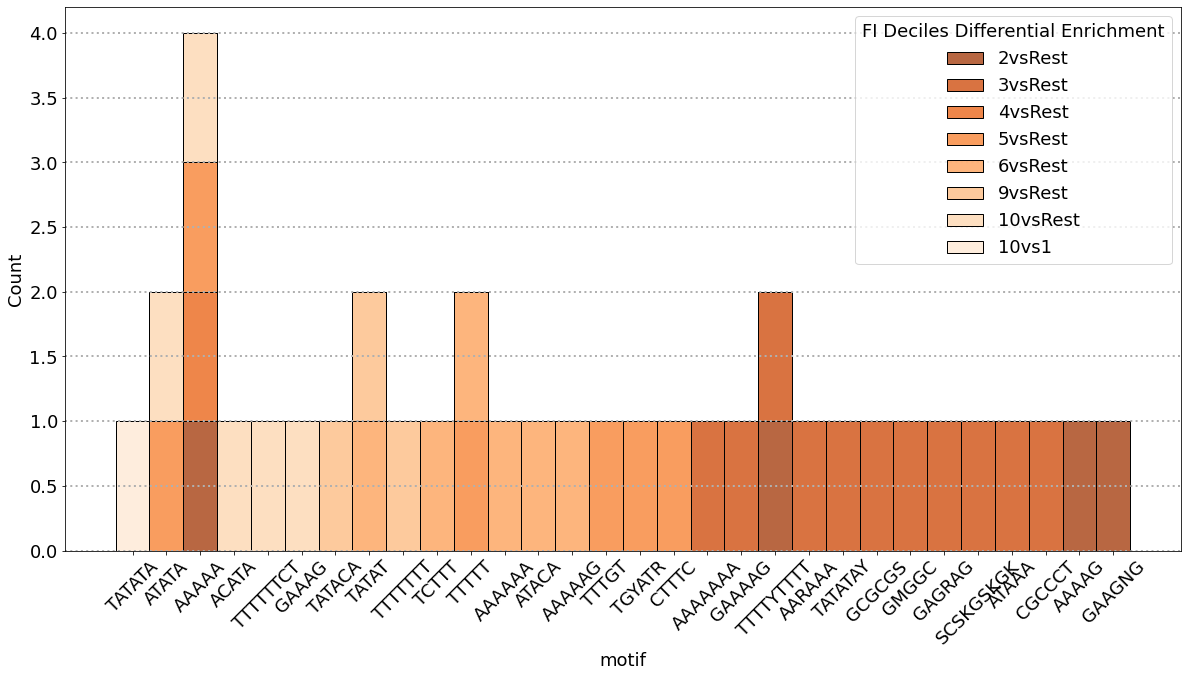

In [80]:
# There may be motifs that are seen more than once inside the motifs list, 
# because of the grouping performed during searching for them based on intensity
plt.figure(figsize=(20,10))
sns.histplot(motifsDecileDf.reset_index(drop=True),x='motif', hue='group', multiple='stack', palette='Oranges', legend=False)
plt.legend(title='FI Deciles Differential Enrichment', loc='upper right', labels=list(dict.fromkeys(motifsDecileDf['group'])))
_ = plt.xticks(rotation=45)
plt.grid(axis='x')
plt.savefig(f'../figures/motifsCounts{DID}.png', dpi=100)

In [28]:
seqs = [Seq(x) for x in df['utr_seq']]

### Creating Features

In [29]:
def create_features(seqs, motifs):
    scores = np.zeros([len(seqs), len(motifs)])
    counts = np.zeros([len(seqs), len(motifs)])
    for s_c, seq in tqdm(enumerate(seqs)):
        for m_c, motif in enumerate(motifs):
            counts[s_c, m_c] = 0
            if len(seq) < len(motif):
                continue
            weights = motif.pssm
            sc = weights.calculate(seq)
            
            counts[s_c, m_c] = np.sum(sc > 0)
            if not counts[s_c, m_c]:
                continue
            scores[s_c, m_c] = np.median(sc[sc>0])
                
    return counts, scores
    
            
counts, scores = create_features(seqs, motifs)

0it [00:00, ?it/s]

In [30]:
other_feats = ['len_seq', 'len_seq_log', 'at_gc', 'pct_gc', 'molecular_w']
motifs_ids = [str(m.degenerate_consensus) for m in motifs]
motifs_scores_ids = [c + '_score' for c in motifs_ids]
motifs_tfidf_ids = [c + '_tfidf' 
                    for c in motifs_ids]
seq_columns = motifs_scores_ids + motifs_tfidf_ids
# seq_columns = motifs_tfidf_ids
uni_ind = list(set([seq_columns.index(x) for x in seq_columns]))
features = np.array(seq_columns)[uni_ind].tolist()
columns_scores = [feat for feat in features if feat.endswith('_score')]
columns_tfidf = [feat for feat in features if feat.endswith('_tfidf')]
# columns_tfidf = features

In [31]:
tfidf = TfidfTransformer().fit_transform(counts)
tfidf = tfidf.todense()
featDf = pd.DataFrame(np.hstack([scores, tfidf]), columns=seq_columns)
# featDf = pd.DataFrame(tfidf, columns=seq_columns)
featDf = featDf.iloc[:,uni_ind]
featDf[:] = SimpleImputer().fit_transform(featDf)
features += other_feats
featDf = pd.concat([featDf,df[other_feats + ['intensity', 'int_group']]], axis=1)
featDf.head()
featDf.set_index(df['gene'].values, inplace=True)

In [32]:
with open('../processed_data/utrs_tfidf.pkl', 'wb') as out:
    pickle.dump(featDf, out)

### Features Exploration / Analysis

Checking for significant difference in FI between genes with and without a found motif.

In [33]:
p_vals = {}
for e in columns_tfidf:
    grp0 = featDf.loc[featDf[e] == 0].intensity
    grp1 = featDf.loc[featDf[e] != 0].intensity
    f_val, p_val = stats.ttest_ind(grp0, grp1)   
    p_vals[e.replace('_tfidf', '')] = p_val
#     p_vals[e] = p_val
anovaPresence = pd.Series(p_vals).reset_index().rename(columns={'index':'motif', 0:'pval'})
anovaPresence = anovaPresence.merge(motifsDecileDf, on='motif')

In [34]:
anovaPresence['qval'] = fdrcorrection(anovaPresence['pval'])[1]
anovaPresence = anovaPresence.sort_values('qval').reset_index(drop=True)
anovaPresence.head()

motif          pval  group         group_type          qval
0  TATATAY  4.802455e-12      9  fi_decile_vs_rest  1.776908e-10
1    TTTTT  7.204016e-10      5  fi_decile_vs_rest  8.884953e-09
2    TTTTT  7.204016e-10      4  fi_decile_vs_rest  8.884953e-09
3    TATAT  1.940273e-08      3  fi_decile_vs_rest  1.435802e-07
4    TATAT  1.940273e-08      4  fi_decile_vs_rest  1.435802e-07

In [35]:
anovaPresence['log_qval'] = -np.log10(anovaPresence['qval'])

In [36]:
sig_mots = anovaPresence.drop_duplicates('motif').query('qval < 0.01')

In [37]:
len(sig_mots)

17

In [38]:
sig_mots['motif'].values.tolist()

['TATATAY',
 'TTTTT',
 'TATAT',
 'AARAAA',
 'TTTGT',
 'TATATA',
 'TTTTYTTTT',
 'TCTTT',
 'ATATA',
 'AAAAAA',
 'TGYATR',
 'ATAAA',
 'GAAGNG',
 'AAAAAAA',
 'AAAAA',
 'CTTTC',
 'TTTTTTT']

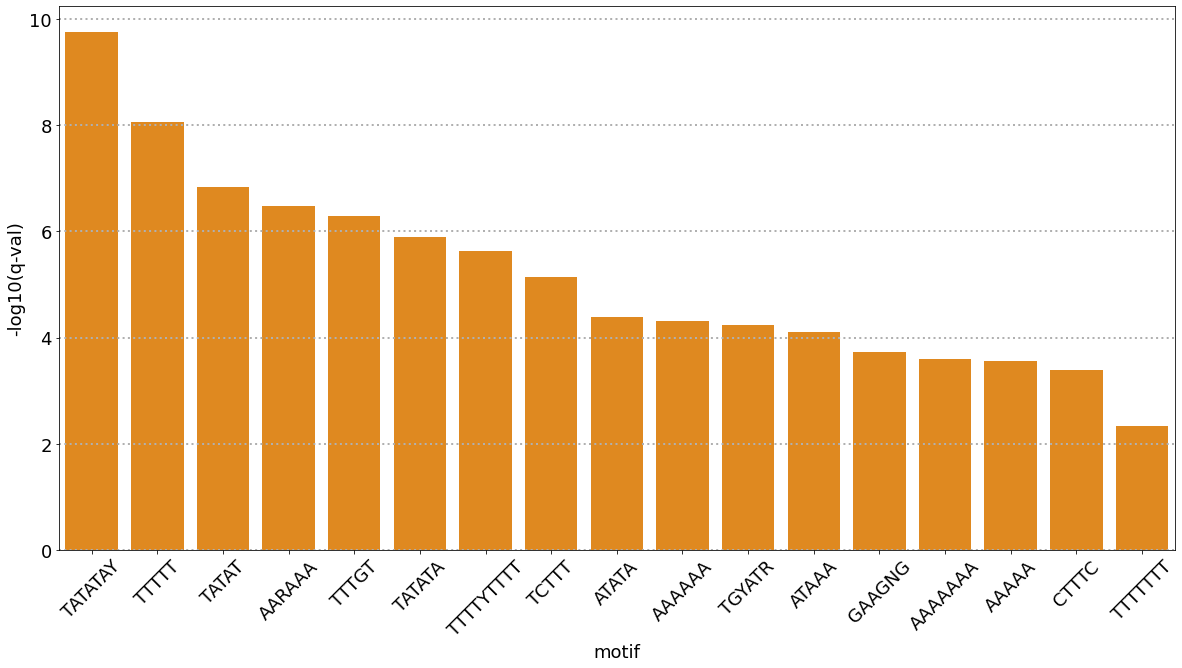

In [39]:
plt.figure(figsize=(20,10))
sns.barplot(data=anovaPresence[anovaPresence['qval']<0.01].drop_duplicates('motif'), x='motif', y='log_qval',color='darkorange')
plt.xticks(rotation=45)
plt.ylabel('-log10(q-val)')
# _ = plt.title("Q-Value of motif presence effect on FI")
plt.savefig(f'../figures/motifsPresenceQvalues{DID}.png', dpi=100)

### PCA

In [40]:
normFeatDf = featDf[features].copy()
# normFeatDf = df_6mers_test.loc[:, (df_6mers.columns != 'gene') & (df_6mers.columns != 'intensity')]
normFeatDf = (normFeatDf-normFeatDf.mean())/normFeatDf.std()
# normFeatDf = (normFeatDf-normFeatDf.min())/(normFeatDf.max()-normFeatDf.min())

In [41]:
pca = PCA(n_components = 7)
components = pca.fit_transform(normFeatDf)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(7),
    color=df.int_group,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [42]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_) * 20

x = 0
y = 1

fig = px.scatter(components, x=x, y=y, color=df.int_group)

for i, feature in enumerate(normFeatDf.columns):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, x],
        y1=loadings[i, y]
    )
    fig.add_annotation(
        x=loadings[i, x],
        y=loadings[i, y],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [43]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [44]:
mapper = UMAP().fit(normFeatDf[features])

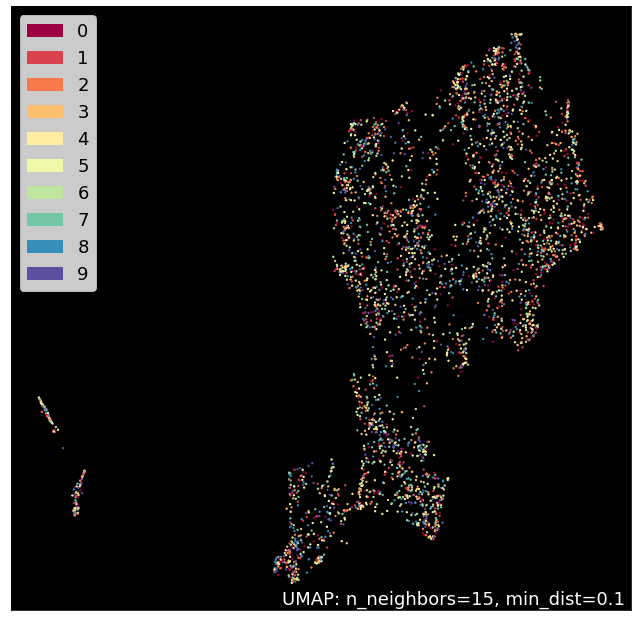

In [45]:
umap.plot.points(mapper, labels=featDf['int_group'], theme="viridis")
plt.savefig(f'../figures/seqbasedfeatsumap{DID}.png', dpi=100)

In [46]:
all_motifs_str = [str(m.degenerate_consensus) for m in motifs]

/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



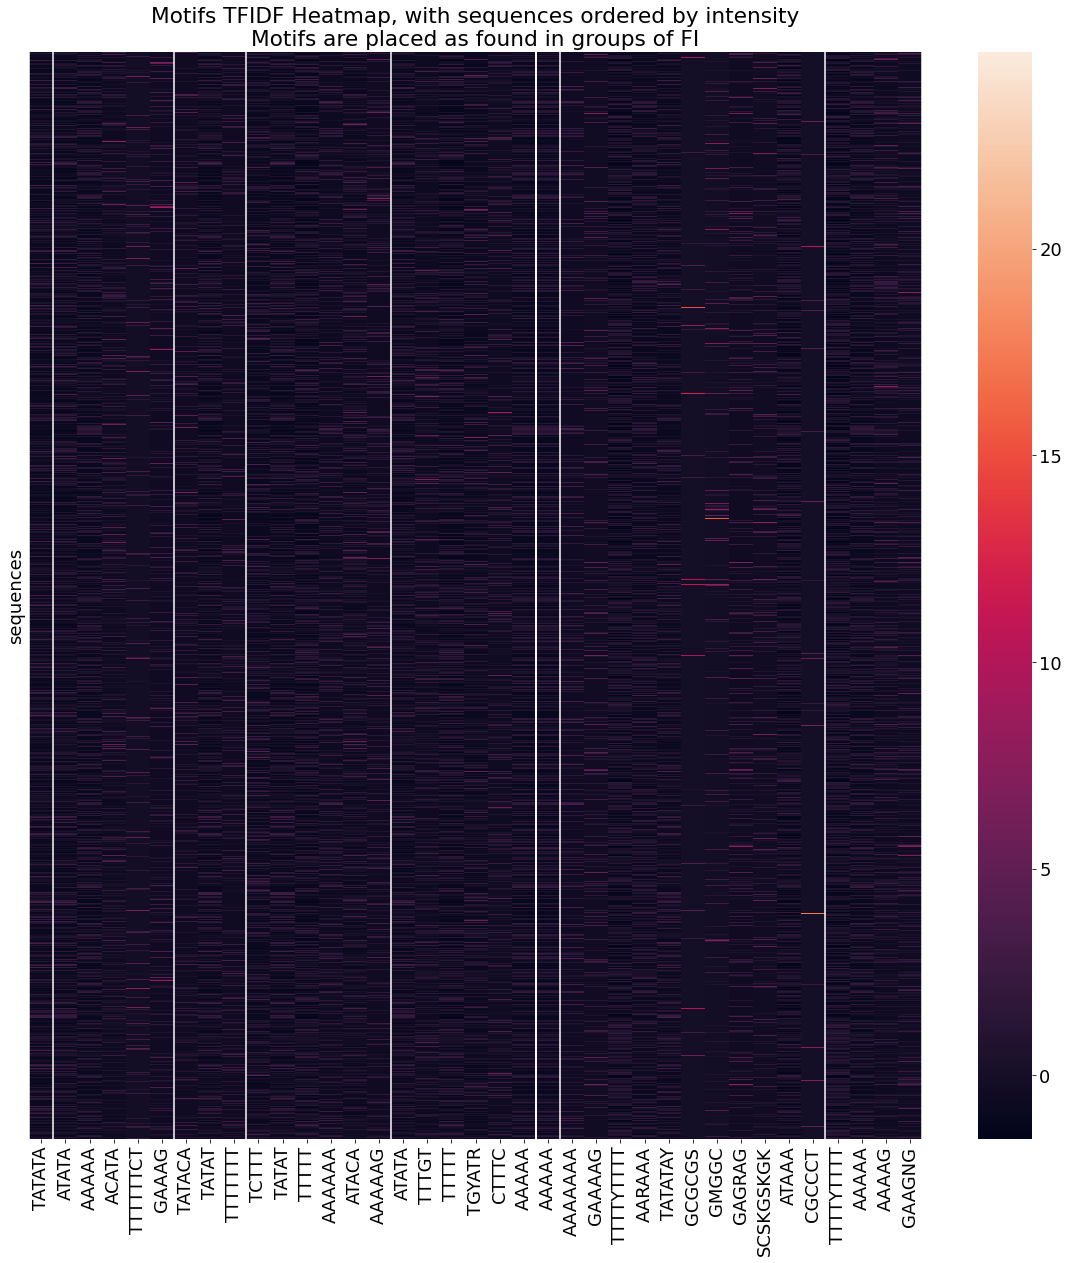

<Figure size 1440x1440 with 0 Axes>

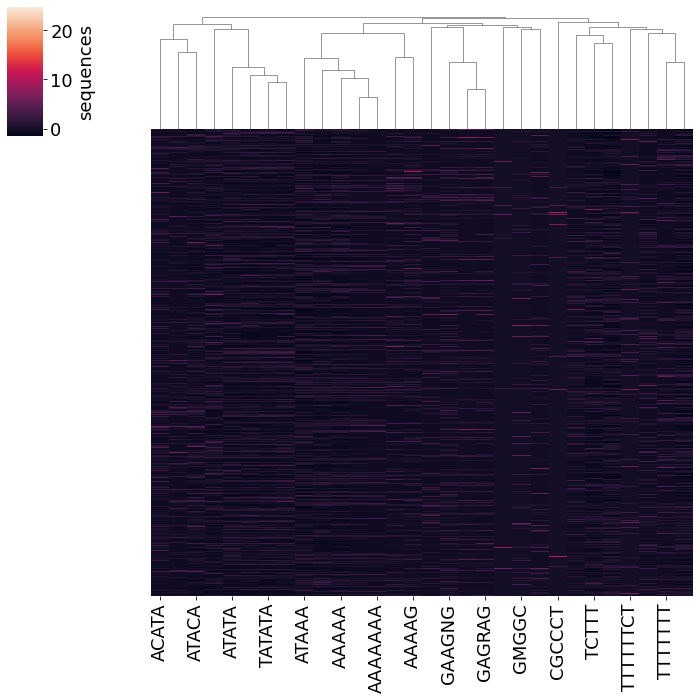

In [47]:
tfidfDf = normFeatDf[columns_tfidf].rename(columns=lambda x: x.replace('_tfidf', ''))
tfidfDfFeats = tfidfDf.columns.tolist()
tfidfDf['intensity'] = featDf.intensity
plt.figure(figsize=(20,20))
ax = sns.heatmap(tfidfDf.sort_values('intensity')[all_motifs_str],yticklabels=False)
_ = ax.vlines(np.cumsum([len(motifs_s[x]) for x in range(11)]), 0, ax.get_xlim()[1] * 100, colors='w')
plt.title('Motifs TFIDF Heatmap, with sequences ordered by intensity\nMotifs are placed as found in groups of FI')
plt.ylabel('sequences')
plt.savefig('../figures/motifTfidfHeatmap{DID}.png', dpi=100)
plt.figure(figsize=(20,20))
_ = sns.clustermap(tfidfDf.sort_values('intensity')[tfidfDfFeats],yticklabels=False,row_cluster=False)
plt.ylabel('sequences')
plt.savefig(f'../figures/motifTfidfClustermap{DID}.png', dpi=100)

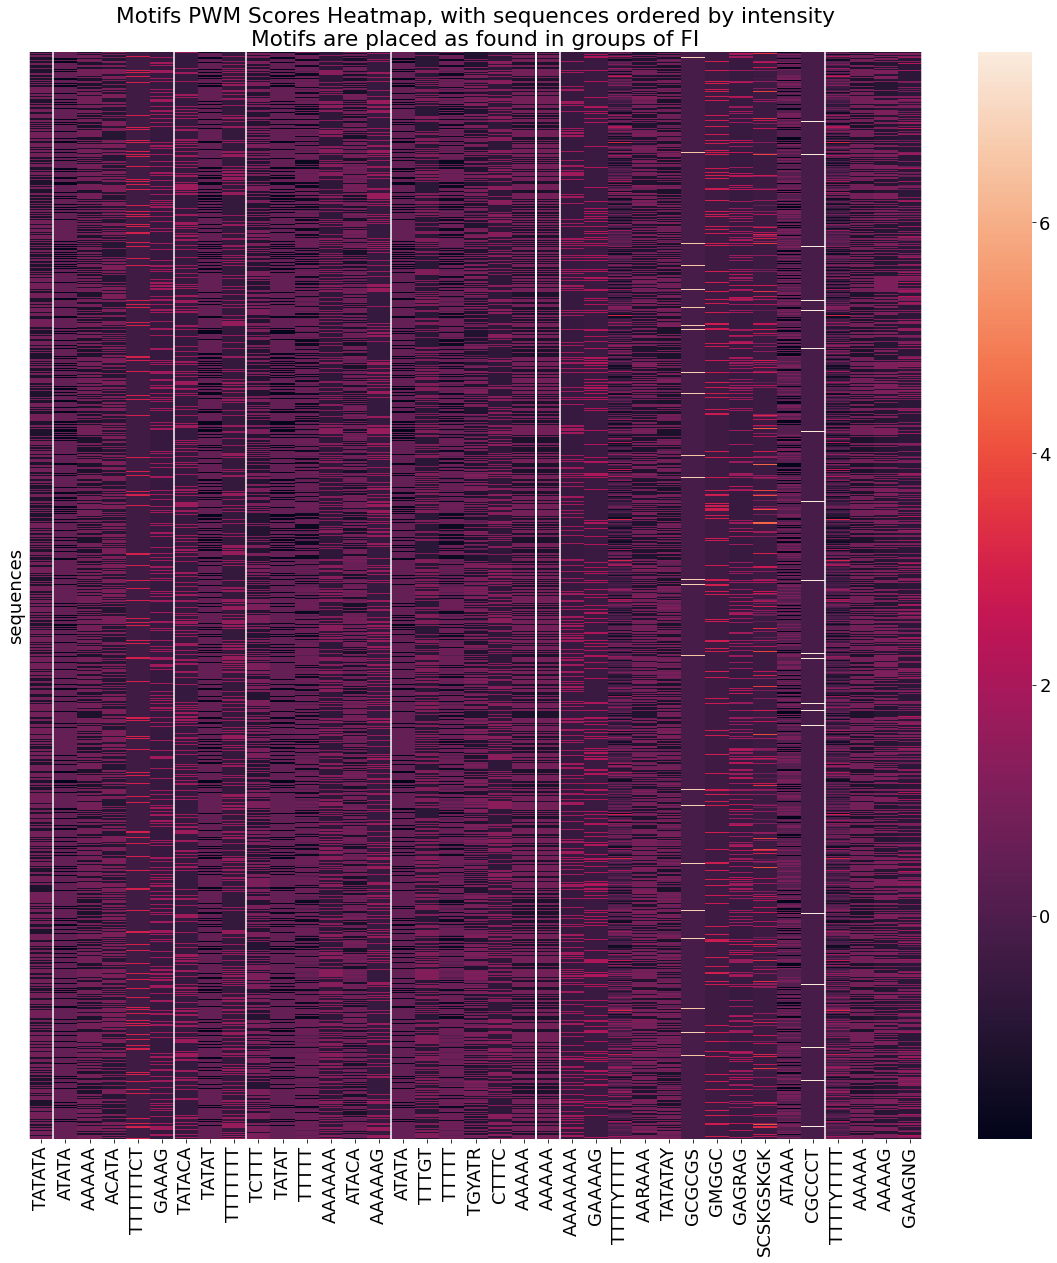

<Figure size 1440x1440 with 0 Axes>

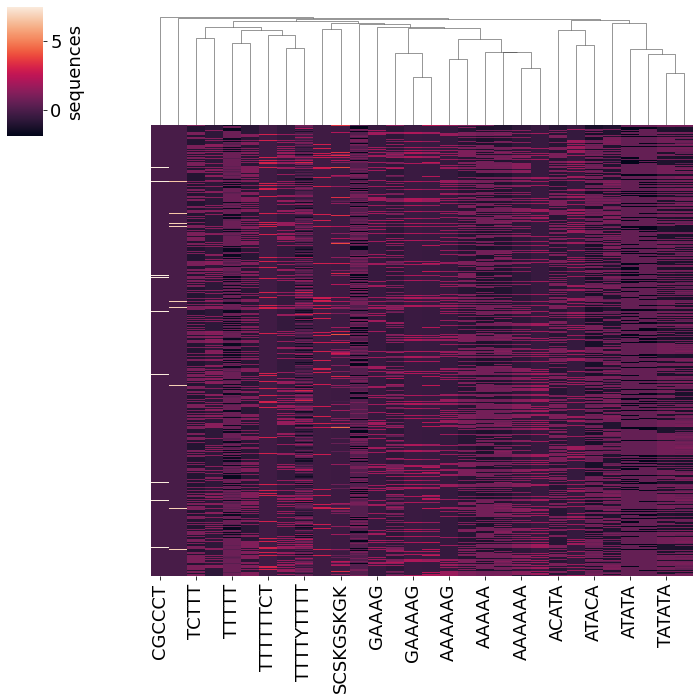

In [48]:
scoreDf = normFeatDf[columns_scores].rename(columns=lambda x: x.replace('_score', ''))
scoreDfFeats = scoreDf.columns.tolist()
scoreDf['intensity'] = featDf.intensity
plt.figure(figsize=(20,20))
ax = sns.heatmap(scoreDf.sort_values('intensity')[all_motifs_str],yticklabels=False)
_ = ax.vlines(np.cumsum([len(motifs_s[x]) for x in range(11)]), 0, ax.get_xlim()[1] * 100, colors='w')
plt.title('Motifs PWM Scores Heatmap, with sequences ordered by intensity\nMotifs are placed as found in groups of FI')
plt.ylabel('sequences')
plt.savefig(f'../figures/motifScoresHeatmap{DID}.png', dpi=100)
plt.figure(figsize=(20,20))
_ = sns.clustermap(scoreDf.sort_values('intensity')[scoreDfFeats],yticklabels=False,row_cluster=False)
plt.ylabel('sequences')
plt.savefig(f'../figures/motifScoresClustermap{DID}.png', dpi=100)

### Classification (RF)
Does a sequence belong to the upper (decile>=5) or lower FI range?

In [49]:
df_subset = featDf.copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X = df_subset.loc[:,features]
y = df_subset.int_bool
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)

Checking how well a Decision Tree can distinguish the label

findfont: Font family ['poppins'] not found. Falling back to DejaVu Sans.


Mean accuracy score: 0.598


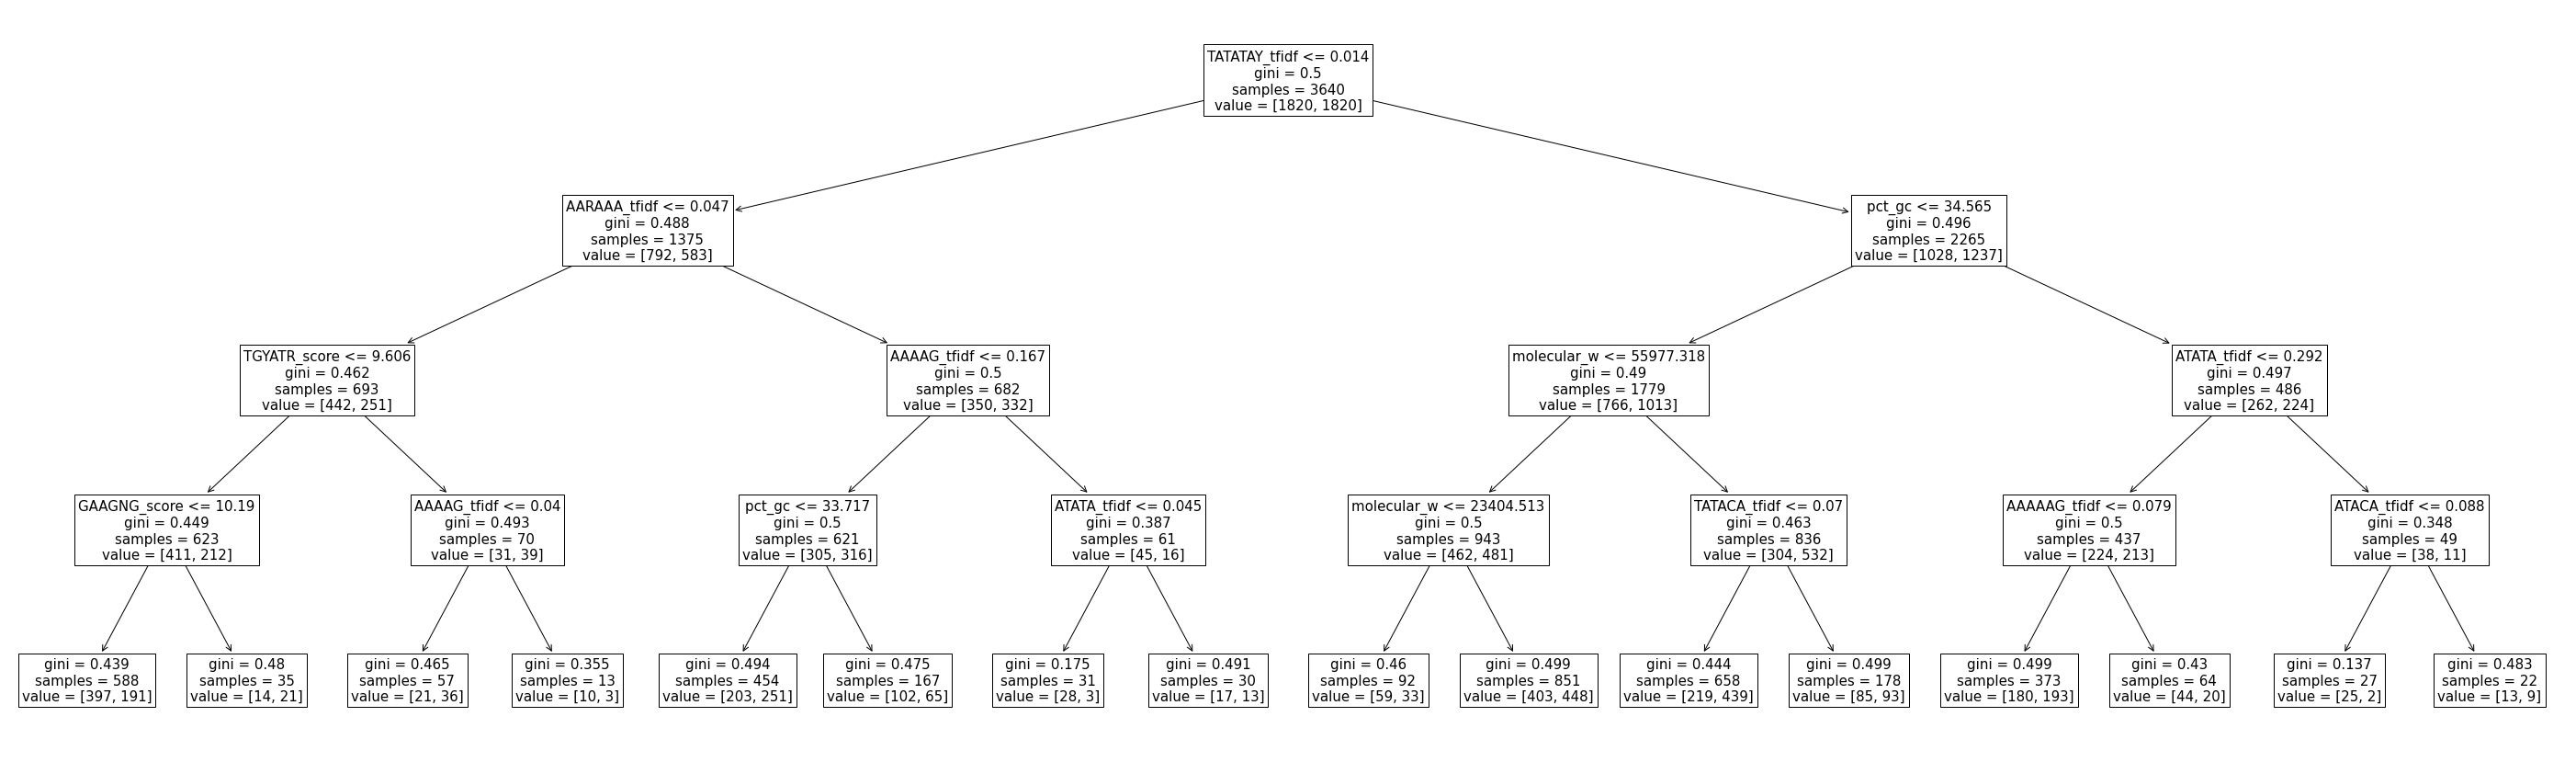

In [50]:
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X, y)
predicted = t.predict(X)
accuracy = accuracy_score(y, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)

In [51]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)

In [52]:
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.571
Mean accuracy score: 1.0


In [53]:

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.571
Mean accuracy score: 0.561


<AxesSubplot:>

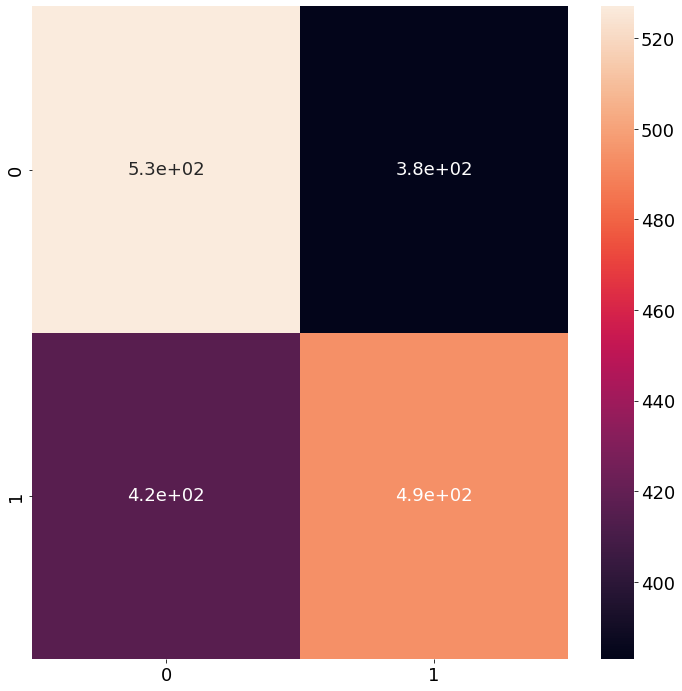

In [54]:

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True)

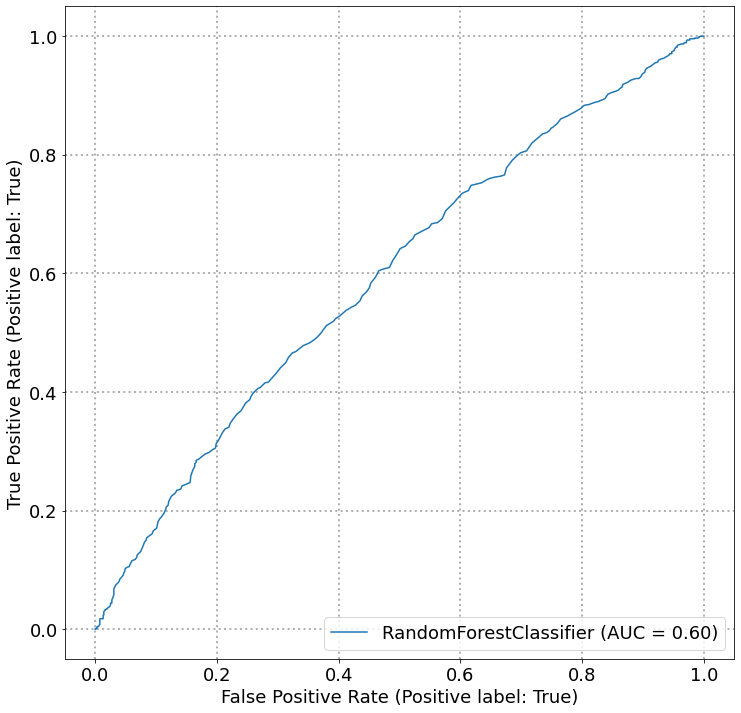

In [55]:
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

### Regression (RF)

In [56]:
df_subset.shape

(3640, 68)

In [57]:
df_subset = featDf.copy()
X = df_subset.loc[:,features]
y = df_subset.intensity

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

Checking how well a Decision Tree can distinguish intensities

MSE: 3.09


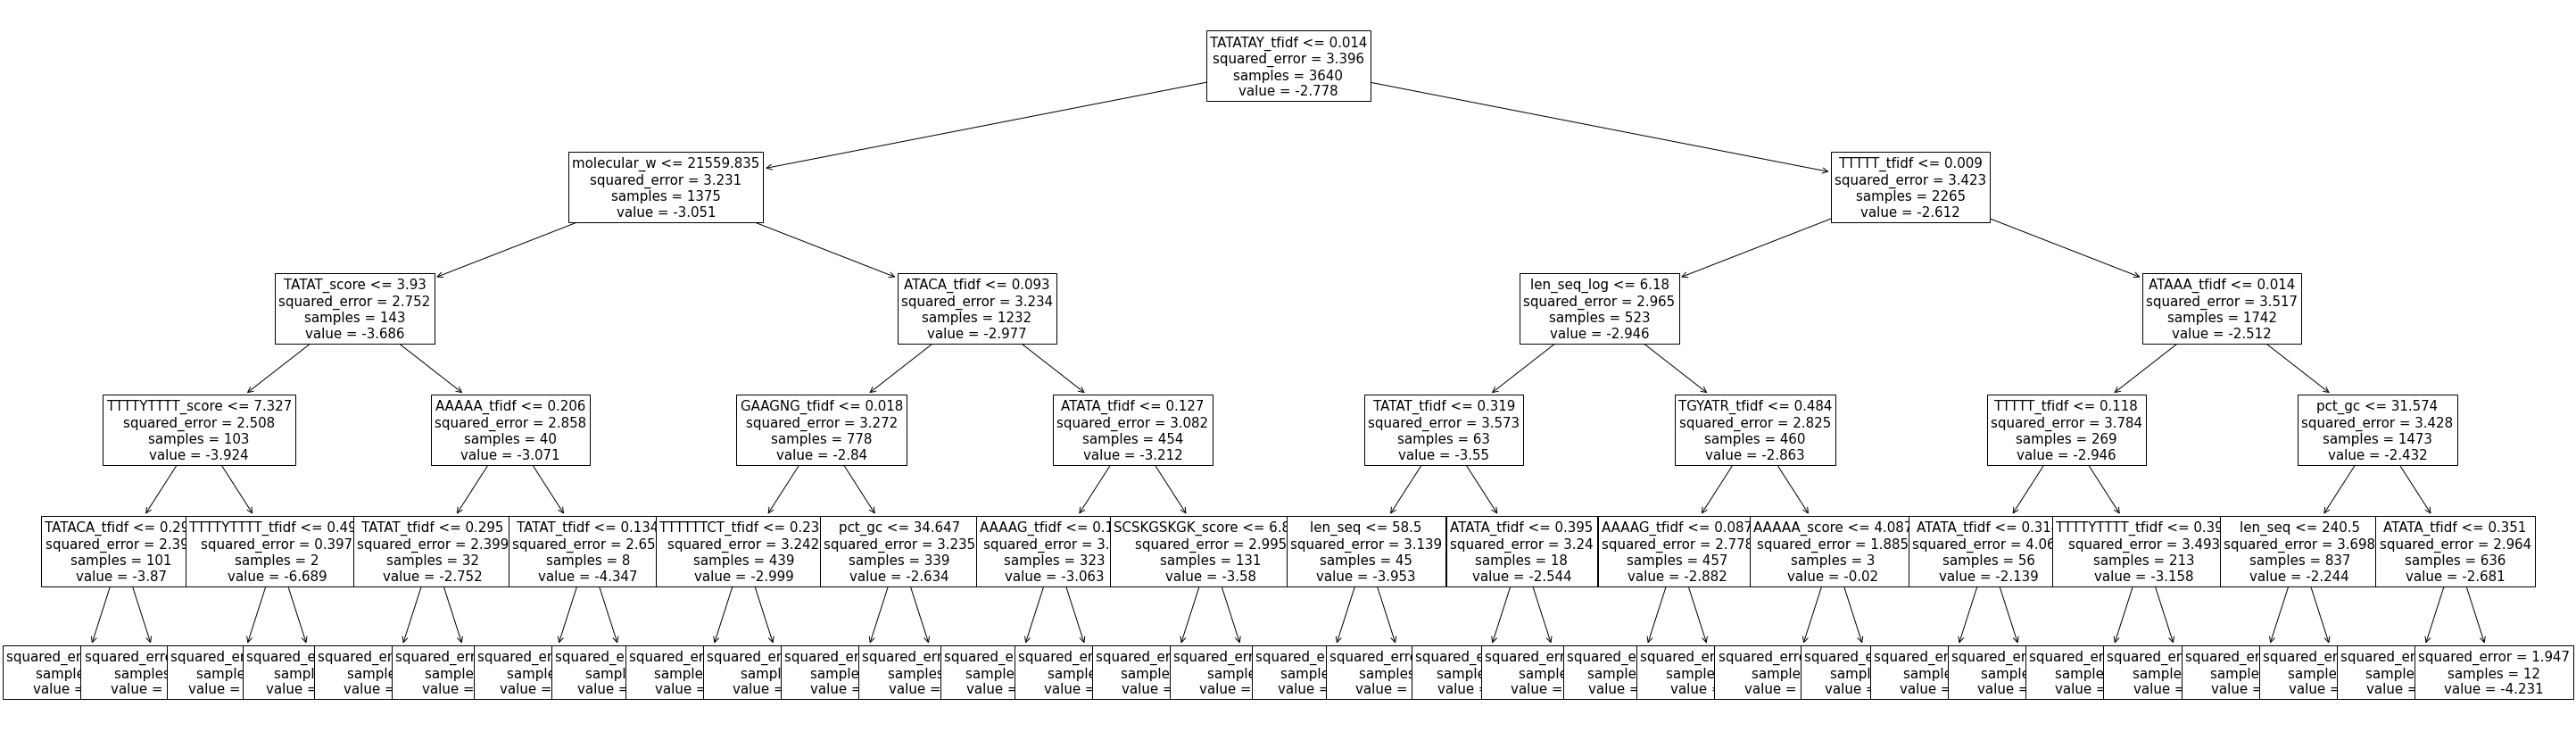

In [58]:
t = DecisionTreeRegressor(random_state=123456, max_depth=5)
t.fit(X, y)
predicted = t.predict(X)
m = mse(y, predicted)
print(f'MSE: {m:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)

In [59]:
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0)

In [60]:
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
m = mse(y_test, predicted_test)
print(f'Test data MSE: {m:.3}')
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Test data MSE: 3.17
Out-of-bag R-2 score estimate: 0.0156
Test data R-2 score: 0.0431
Test data Spearman correlation: 0.194
Test data Pearson correlation: 0.211


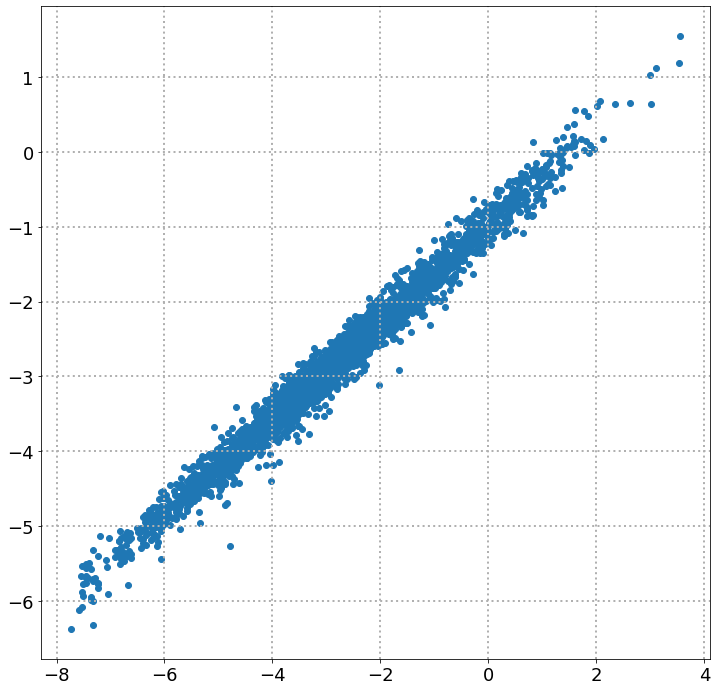

In [61]:
plt.scatter(y_train, predicted_train)

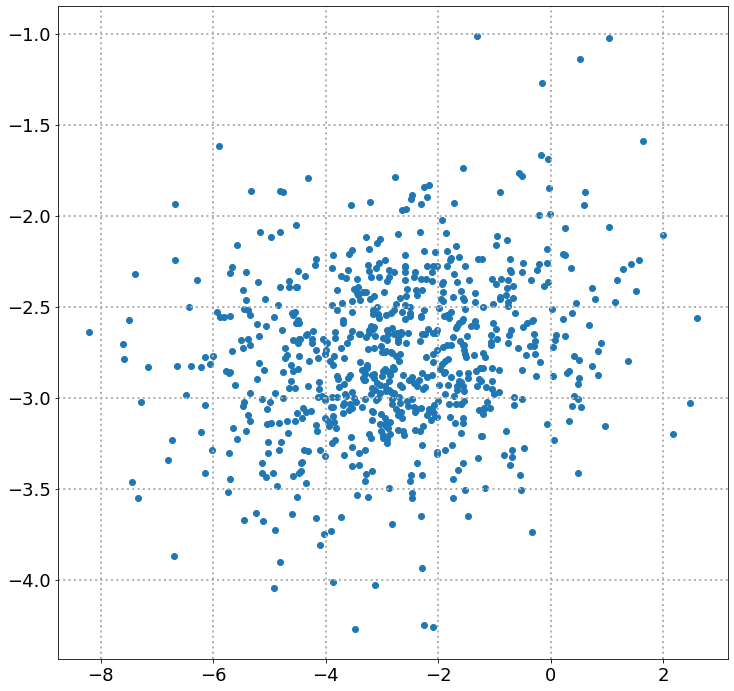

In [62]:
plt.scatter(y_test, predicted_test)

### Try only with last group motifs (9 vs 0) features and using groups 0 and 9

In [63]:

subset_feats = ([x + '_score' for x in motifs_s[10]] +
                [x + '_tfidf' for x in motifs_s[10]])
# subset_feats = motifs_s[10]
df_subset = featDf.loc[featDf['int_group'].isin([0,9]), subset_feats + ['int_group']
                       ].copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X = df_subset[subset_feats]
y = df_subset.int_bool

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy train score: {accuracy:.3}')
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy test score: {accuracy:.3}')

/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Out-of-bag score estimate: 0.5
Mean accuracy train score: 0.997
Mean accuracy test score: 0.591


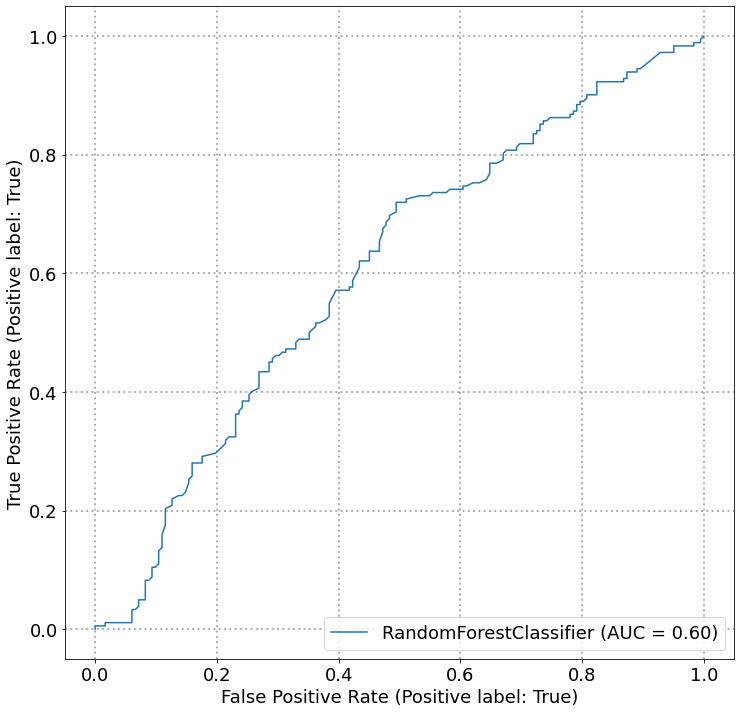

In [64]:
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

Mean accuracy score: 0.635


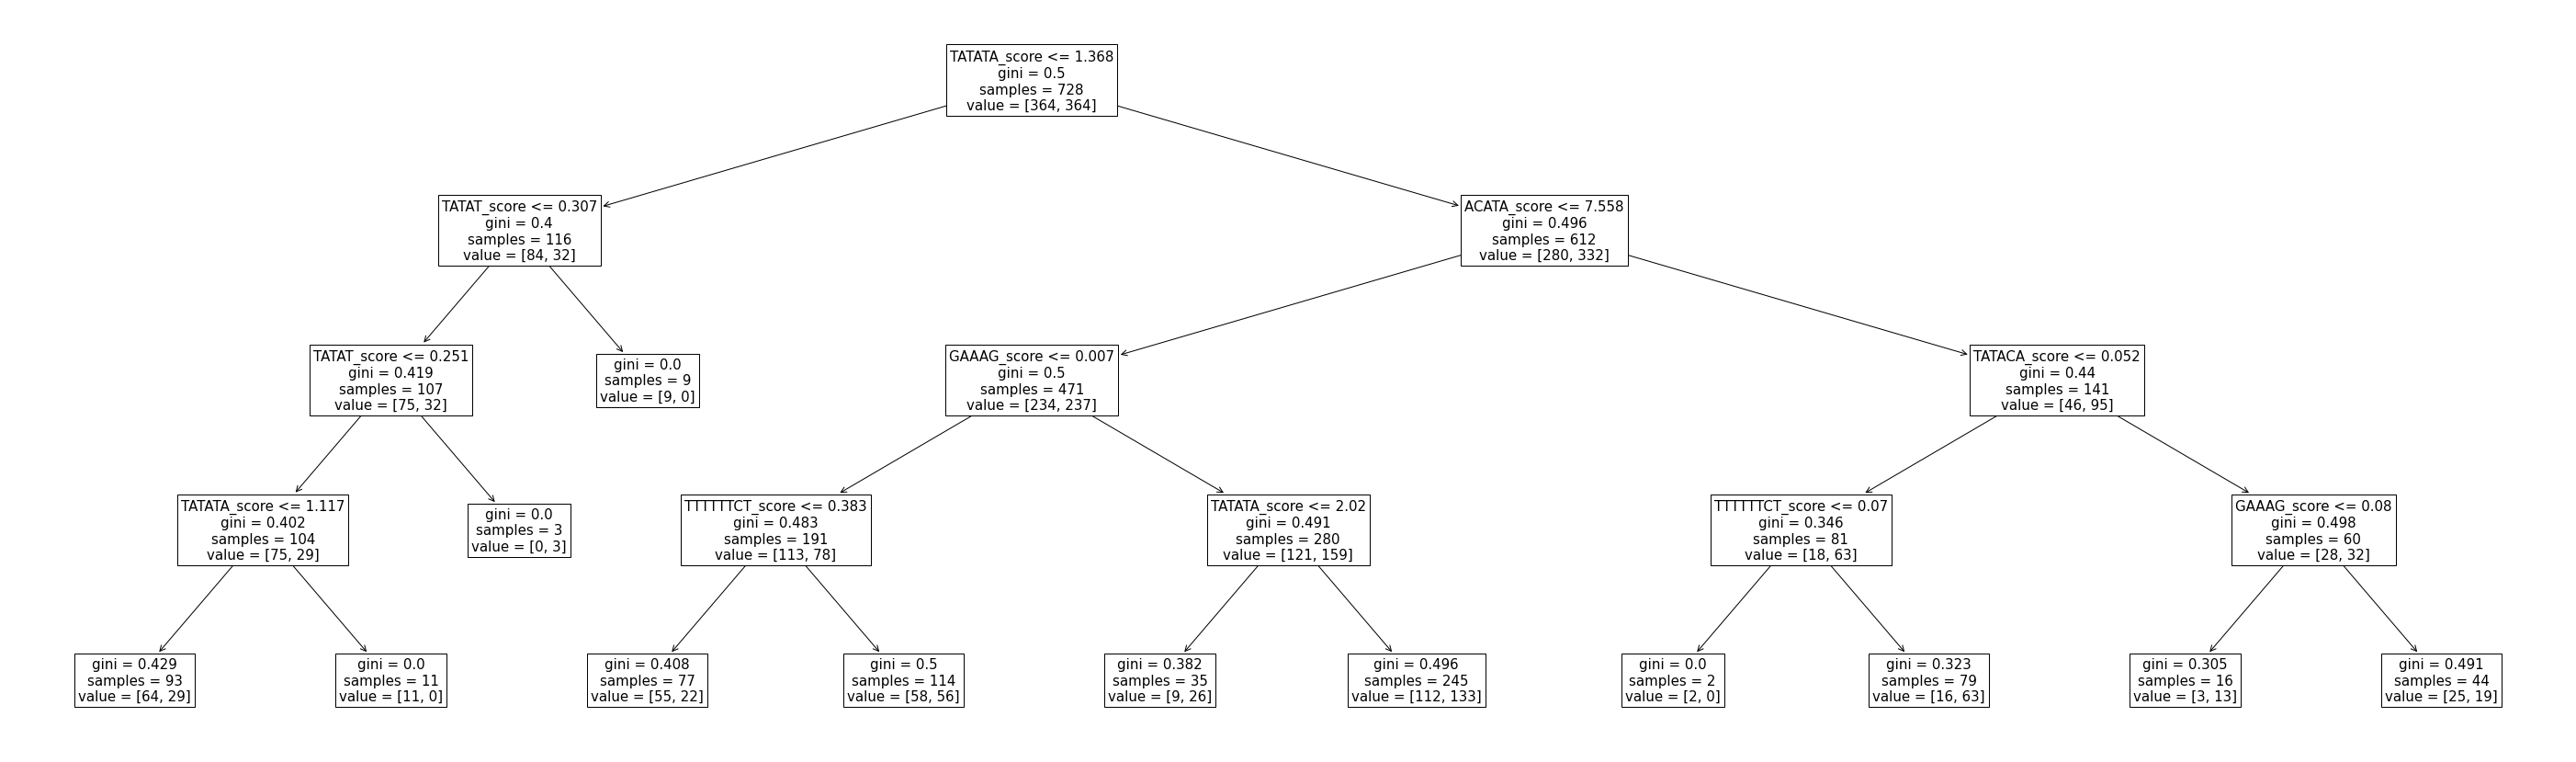

In [65]:
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X, y)
predicted = t.predict(X)
accuracy = accuracy_score(y, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)
plt.savefig(f'../figures/motifs9vs0{DID}.png', dpi=100)